In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder

In [0]:
train = pd.read_csv('/content/drive/My Drive/화재예측/train_pre.csv',engine='python')
test = pd.read_csv('/content/drive/My Drive/화재예측/test_pre.csv',engine='python')
valid = pd.read_csv('/content/drive/My Drive/화재예측/valid_pre.csv',engine='python')

# 전처리

In [0]:
input_var = list(set(train.columns) - set(['id','dt_of_fr','fr_yn']))
target = ['fr_yn']

In [0]:
cate_col = []
for col in train[input_var].columns:
    if (train[col].dtype == 'object'):
        cate_col.append(col)
    
cate_col = list(set(cate_col + ['year','month','hour','weekday','wnd_drctn']))

In [6]:
for col in tqdm_notebook(train.columns): 
    if col in cate_col:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(valid[col].astype(str).values)+ list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        valid[col] = le.transform(list(valid[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [0]:
for i in enumerate (cate_col) : 
    ca = i[1] 
    train[ca] = train[ca].astype('category') 
    valid[ca] = valid[ca].astype('category') 
    test[ca] = test[ca].astype('category') 

In [0]:
train[cate_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59199 entries, 0 to 59198
Data columns (total 21 columns):
lnd_us_sttn_nm                  59199 non-null category
emd_nm2                         59199 non-null category
emd_nm3                         59199 non-null category
mlt_us_yn                       59199 non-null category
bldng_us                        59199 non-null category
weekday                         59199 non-null category
rgnl_ar_nm                      59199 non-null category
bldng_archtctr                  59199 non-null category
jmk                             59199 non-null category
fr_fghtng_fclt_spcl_css_6_yn    59199 non-null category
trgt_crtr                       59199 non-null category
wnd_drctn                       59199 non-null category
year                            59199 non-null category
dngrs_thng_yn                   59199 non-null category
rd_sd_nm                        59199 non-null category
month                           59199 non-null cate

In [0]:
X_train = train[input_var]
y_train = train['fr_yn']

X_valid = valid[input_var]
y_valid = valid['fr_yn']

In [0]:
X_train.shape

(59199, 184)

# 파라미터

In [0]:
from sklearn.metrics import f1_score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [0]:
params = {'iterations': 0.8759278817295955,
 'od_wait': 0.7659541126403374,
 'learning_rate': 0.007897842804285066,
 'depth': 34,
 'min_child_weight': 0.01842211053435804,
 'min_data_in_leaf': 68,
 'bagging_temperature': 0.5247039559890746,
 'od_type': 160,
 'metric_period': 0.2912000172840221,
 }
params['objective'] = 'binary'
params['eval_metric'] = 'None'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_seed'] = 47

cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

# rfe

## RFE 전처리

In [0]:
cate_col = []
for col in train[input_var].columns:
    if (train[col].dtype == 'object'):
        cate_col.append(col)
    
cate_col = list(set(cate_col + ['year','month','hour','weekday','wnd_drctn']))

#for i in enumerate (cate_col) : 
#    ca = i[1] 
#    train[ca] = train[ca].astype('category') 
#    valid[ca] = valid[ca].astype('category') 
#    test[ca] = test[ca].astype('category') 

In [0]:
train2 = train.copy()
vt = pd.concat([valid,test], axis=0) 
#for col in cate_col:
    #train2 = train2.loc[train2[col].isin(list(set(train2[col].unique()) & set(vt[col].unique())))]

In [0]:
for col in tqdm_notebook(train2.columns): 
    if col in cate_col:
        le = LabelEncoder()
        le.fit(list(train2[col].astype(str).values) + list(valid[col].astype(str).values)+ list(test[col].astype(str).values))
        train2[col] = le.transform(list(train2[col].astype(str).values))
        valid[col] = le.transform(list(valid[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [0]:
train2['ad'] = 2
valid['ad'] =1
test['ad'] = 0
all_df = pd.concat([train2, valid, test], axis=0).reset_index().drop('index',axis=1)
all_df = pd.get_dummies(all_df[input_var+['ad']], columns=cate_col)

X_train = all_df[all_df.ad==2].drop('ad', axis=1)
X_valid = all_df[all_df.ad==1].drop('ad', axis=1)
X_test = all_df[all_df.ad==0].drop('ad', axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [0]:
X_train.shape, X_valid.shape,  X_test.shape

((59199, 683), (6898, 683), (2957, 683))

In [0]:
X_valid =X_valid.fillna(-99)

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
X_valid = reduce_mem_usage(X_valid)

Mem. usage decreased to  7.32 Mb (39.3% reduction)


In [0]:
lgb_valid = lgb.Dataset(X_valid,label = y_valid)

## RFE 학습 및 결과

In [0]:
clf = lgb.LGBMClassifier(**params, categorical_feature= cate_col)
rfe = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10), scoring='f1', verbose=2)
rfe.fit(X_valid, y_valid)

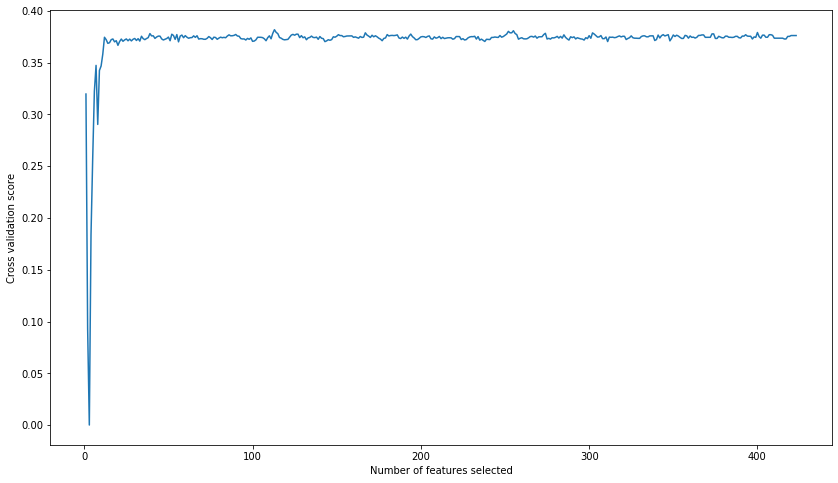

In [0]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [0]:
len(X_valid.columns[rfe.ranking_ == 1])

113

In [0]:
list(X_valid.columns[rfe.ranking_ == 1])

['e_std_10',
 'g_median_05',
 'e_min_03',
 'e_min_01',
 'e_median_01',
 'e_median_05',
 'g_std_03',
 'hmdt',
 'g_std_06',
 'lw_13101211',
 'sft_emrgnc_bll_dstnc',
 'g_std_01',
 'e_max_04',
 'g_mean_08',
 'g_median_06',
 'g_min_09',
 'lw_13101410',
 'e_max_07',
 'e_max_06',
 'e_mean_11',
 'g_mean_05',
 'g_min_01',
 'e_max_11',
 'e_std_07',
 'e_std_09',
 'fr_wthr_fclt_dstnc',
 'g_min_05',
 'e_mean_06',
 'e_std_03',
 'g_median_07',
 'e_min_07',
 'lw_13121011',
 'g_mean_01',
 'g_mean_12',
 'g_min_03',
 'g_std_08',
 'e_mean_12',
 'fr_sttn_dstnc',
 'e_max_09',
 'ttl_grnd_flr',
 'e_std_01',
 'dwn_ar',
 'e_min_06',
 'e_mean_03',
 'e_mean_04',
 'g_min_07',
 'lnd_ar',
 'gas_dday',
 'e_max_10',
 'e_max_03',
 'cctv_dstnc',
 'bldng_ar_prc',
 'e_median_11',
 'hm_cnt',
 'e_std_12',
 'bldng_cnt',
 'e_mean_10',
 'e_mean_09',
 'bldng_ar',
 'e_mean_07',
 'dt_of_athrztn',
 'bldng_cnt_in_50m',
 'ttl_ar',
 'grnd_ar',
 'ahsm_dstnc',
 'e_std_08',
 'e_mean_08',
 'tbc_rtl_str_dstnc',
 'no_tbc_zn_dstnc',
 'e_max

In [0]:
rfe_col = ['jmk','bldng_us_clssfctn','emd_nm3','emd_nm2','fr_fghtng_fclt_spcl_css_6_yn','rd_sd_nm','bldng_archtctr','lnd_us_sttn_nm',
'e_std_10', 
 'g_median_05',
 'e_min_03',
 'e_min_01',
 'e_median_01',
 'e_median_05',
 'g_std_03',
 'hmdt',
 'g_std_06','lw_13101211','sft_emrgnc_bll_dstnc','g_std_01','e_max_04','g_mean_08','g_median_06','g_min_09','lw_13101410','e_max_07','e_max_06','e_mean_11','g_mean_05',
'g_min_01',
 'e_max_11',
 'e_std_07',
 'e_std_09',
 'fr_wthr_fclt_dstnc',
 'g_min_05',
 'e_mean_06',
 'e_std_03',
 'g_median_07',
 'e_min_07',
 'lw_13121011',
 'g_mean_01',
 'g_mean_12',
 'g_min_03',
 'g_std_08',
 'e_mean_12',
 'fr_sttn_dstnc',
 'e_max_09',
 'ttl_grnd_flr',
 'e_std_01',
 'dwn_ar',
 'e_min_06',
 'e_mean_03',
 'e_mean_04',
 'g_min_07',
 'lnd_ar',
 'gas_dday',
 'e_max_10',
 'e_max_03',
 'cctv_dstnc',
 'bldng_ar_prc',
 'e_median_11',
 'hm_cnt',
 'e_std_12',
 'bldng_cnt',
 'e_mean_10',
 'e_mean_09',
 'bldng_ar',
 'e_mean_07',
 'dt_of_athrztn',
 'bldng_cnt_in_50m',
 'ttl_ar',
 'grnd_ar',
 'ahsm_dstnc',
 'e_std_08',
 'e_mean_08',
 'tbc_rtl_str_dstnc',
 'no_tbc_zn_dstnc',
 'e_max_05',
 'e_max_08',
 'e_max_01',
 'wnd_spd',
 'e_max_02',
 'e_std_11',
 'tmprtr',
 'bldng_us']
rfe_cat_col = ['jmk','bldng_us_clssfctn','emd_nm3','emd_nm2','fr_fghtng_fclt_spcl_css_6_yn','rd_sd_nm','bldng_archtctr','lnd_us_sttn_nm','bldng_us']
len(rfe_col)

85

# 수동 RFE

In [0]:
!pip install shap

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376827 sha256=876b73e688061a15f603de240c34e09fd70812ad5139051ab352a63b8848ea7c
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(X_valid)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_valid.columns.tolist(), shap_sum.mean(axis=0).tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [0]:
params = {'bagging_fraction': 0.8759278817295955,
 'feature_fraction': 0.7659541126403374,
 'learning_rate': 0.007897842804285066,
 'max_depth': 34,
 'min_child_weight': 0.01842211053435804,
 'min_data_in_leaf': 68,
 'neg_bagging_fraction': 0.5247039559890746,
 'num_leaves': 160,
 'pos_bagging_fraction': 0.2912000172840221,
 'reg_alpha': 3.0592683550829505,
 'reg_lambda': 0.6974779083216026,
 'is_unbalance': True,
         'use_missing':True
          }
params['objective'] = 'binary'
params['metric'] = 'None'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

n_estimators = 10000                                                                                                                                                       
verbose = 1000                                                                                                                                                             
early_stopping_rounds = 200 

In [0]:
# 제거하는 컬럼 리스트

drop_columns = list()
dropped_values = list()
CVs = list()
drop_max_columns = -1   # -1 is for: repeat until all but one columns are dropped
dset = X_train # dset으로 원본 코드에 맞게 이름 변경
dset2 = X_valid

thing_to_learn = "fr_yn"

if drop_max_columns == -1:
    drop_max_columns = dset.shape[1] - 1
if drop_max_columns > dset.shape[1]:
    drop_max_columns = dset.shape[1] - 1

In [0]:
from time import time
import warnings

warnings.filterwarnings("ignore")

cate_col2 = cate_col.copy() # 카테고르 변수 리스트 복사
dropped_already = -1

allowed_time = 7.5 * 60 * 60 * 60
start_time = time()
current_time = time()
useful_col = []
while dropped_already < drop_max_columns and (current_time - start_time) < allowed_time:
    CV = 0
    
    X_train, X_valid = dset.drop(drop_columns, axis=1), dset2.drop(drop_columns, axis=1)
    y_train, y_valid = train[thing_to_learn], valid[thing_to_learn]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    model = lgb.train(params, dtrain, n_estimators, valid_sets=[dtrain, dvalid], feval= lgb_f1_score,
                      verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds,
                      categorical_feature = cate_col2)
    
    useful_col.append(list(X_train.columns))
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)

    # Calculate Shap values
    shap_values = explainer.shap_values(X_valid)

    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame([X_valid.columns.tolist(), shap_sum.mean(axis=0).tolist()]).T
    importance_df.columns = ['feature', 'importance']
    importance_df["fold"] = 1

    CV = model.best_score["valid_1"]["f1"] 
      
    # 결과 저장
    fi = pd.DataFrame({"Feature":importance_df.pivot(index="fold", columns="feature", values="importance").columns.values,                                   
                      "Value":importance_df.pivot(index="fold", columns="feature", values="importance").mean().values})
    row = fi.iloc[fi['Value'].idxmin()]
    feature = row["Feature"]
    value = row["Value"]
    print('*************** Mean AUC:', CV, ', ', X_train.shape, feature)
    drop_columns.append(feature)
    if feature in cate_col2: # 카테고리 변수 리스트도 업데이트
      cate_col2.remove(feature)
    dropped_values.append(value)
    CVs.append(CV)
    dropped_already += 1
    current_time = time()

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[89]	training's f1: 0.443019	valid_1's f1: 0.515649
*************** Mean AUC: 0.5156494522691706 ,  (59199, 184) bldng_cnt_in_50m
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[92]	training's f1: 0.469239	valid_1's f1: 0.513858
*************** Mean AUC: 0.5138576779026218 ,  (59199, 183) bldng_us_clssfctn
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[92]	training's f1: 0.470334	valid_1's f1: 0.514786
*************** Mean AUC: 0.5147864184008762 ,  (59199, 182) e_median_01
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[90]	training's f1: 0.447753	valid_1's f1: 0.515323
*************** Mean AUC: 0.5153234960272418 ,  (59199, 181) e_median_02
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:

In [0]:
drop_columns = drop_columns[:-1]
dropped_values = dropped_values[:-1]
drop_columns.insert(0, "Nothing")
dropped_values.insert(0, 0)
deltas = list(np.array(CVs)[:-1] - np.array(CVs)[1:])
deltas.insert(0, 0)
df = pd.DataFrame({"Dropped_feature":drop_columns, "CV_change":deltas, "N_dropped":np.arange(len(CVs)), "CV":CVs})
df

# bayesian

## 정의

In [7]:
!pip install  Bayesian-Optimization

In [0]:
for i in enumerate (cate_col) : 
    ca = i[1] 
    train[ca] = train[ca].astype('str') 
    valid[ca] = valid[ca].astype('str') 
    test[ca] = test[ca].astype('str') 

In [9]:
!pip install catboost

In [0]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier


def Cat_bayesian(
   bagging_temperature ,
                  depth , 
                  learning_rate ,
             #     min_data_in_leaf , 
             #     max_leaves , 
                  l2_leaf_reg , 
                  border_count
     ):
    
    # Catboost expects next three parameters need to be integer. 
    bagging_temperature = int(bagging_temperature)
    border_count = int(border_count)
    l2_leaf_reg = int(l2_leaf_reg)
    depth = int(depth)

    assert type(bagging_temperature) == int
    assert type(border_count) == int
    assert type(l2_leaf_reg) == int
    assert type(depth) == int

  
    params = {}
    params['iterations'] = 2000
    params['eval_metric'] = 'F1'
 #   params['random_seed'] = 1234
    params['learning_rate'] = learning_rate
 #   params['min_data_in_leaf'] = int(round(min_data_in_leaf))
     #params['max_leaves'] = int(round(max_leaves))
    params['depth'] = int(round(depth))
    params['l2_leaf_reg'] = int(round(l2_leaf_reg))
    params['border_count'] = int(round(border_count))
    params['bagging_temperature'] = int(round(bagging_temperature))    
    params['class_weights'] = None

    clf = CatBoostClassifier(**params , 
                                 task_type = "CPU" , 
                                 leaf_estimation_iterations = 10,
                                 use_best_model=True,
                                 od_type="Iter",
                                 verbose=200,
                             early_stopping_rounds = 100
                                )
    cv_result = clf.fit( train[input_var], train['fr_yn'],
                         cat_features=cate_col,
                         eval_set=(valid[input_var], valid['fr_yn']) )
    
    return cv_result.best_score_['validation']['F1']

In [0]:
Cat_bounds = {
    'learning_rate': (0.01,0.0001),
    'bagging_temperature': (10,1000),
    'l2_leaf_reg':(1,200) , 
    'border_count': (1,100),
    'depth':(4,14)
}

In [23]:
import warnings

# 베이지안 opt
Cat_BO = BayesianOptimization(Cat_bayesian, Cat_bounds, random_state=42)
#lgb_train = lgb.Dataset(X_train2,label = y_train)
#lgb_valid = lgb.Dataset(X_valid2,label = y_valid)

init_points = 100
n_iter = 100

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    Cat_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)
  
params = Cat_BO.max['params']

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
0:	learn: 0.4038963	test: 0.4531343	best: 0.4531343 (0)	total: 558ms	remaining: 18m 35s
200:	learn: 0.4075954	test: 0.5178773	best: 0.5210466 (187)	total: 1m 45s	remaining: 15m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5210466439
bestIteration = 187

Shrink model to first 188 iterations.
|  1        |  0.521    |  380.8    |  95.12    |  11.32    |  120.1    |  0.008455 |
0:	learn: 0.4078163	test: 0.4653641	best: 0.4653641 (0)	total: 581ms	remaining: 19m 20s
200:	learn: 0.3855787	test: 0.4892199	best: 0.4917905 (147)	total: 1m 10s	remaining: 10m 34s
400:	learn: 0.4020561	test: 0.4975970	best: 0.4985163 (392)	total: 2m 38s	remaining: 10m 32s
600:	learn: 0.413

KeyboardInterrupt: ignored

In [24]:
Cat_BO.max['params']

{'bagging_temperature': 665.8970615104422,
 'border_count': 31.859396532851683,
 'depth': 9.200680211778108,
 'l2_leaf_reg': 109.79534558931265,
 'learning_rate': 0.008169940890297283}

In [26]:
from catboost import CatBoostClassifier

params = {'bagging_temperature': 666,
 'border_count': 32,
 'depth': 9,
 'l2_leaf_reg': 110,
 'learning_rate': 0.008169940890297283,
    'eval_metric':'F1'}

clf = CatBoostClassifier(**params , 
                                 task_type = "CPU" , 
                                 leaf_estimation_iterations = 10,
                                 use_best_model=True,
                                 od_type="Iter",
                                 verbose=200,
                                )
#simple_model = CatBoostClassifier(**cat_params)

clf.fit(
    train[input_var], train['fr_yn'],
     cat_features=cate_col,
                eval_set=(valid[input_var], valid['fr_yn']),
);

0:	learn: 0.4240401	test: 0.4856093	best: 0.4856093 (0)	total: 267ms	remaining: 4m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4970507275
bestIteration = 10

Shrink model to first 11 iterations.


In [13]:
clf.best_score_['validation']['F1']

0.514797507788162

In [97]:
simple_model.predict(test[input_var])
submission = pd.read_csv('/content/drive/My Drive/화재예측/PJT002_submission.csv')
submission['fr_yn'] = simple_model.predict(test[input_var])
submission['fr_yn'] = np.where(submission['fr_yn']>=0.5, 'Y', 'N')
submission[submission['fr_yn']=='N'].shape[0] / submission.shape[0]

0.8031788975312817

In [0]:
submission.to_csv('/content/drive/My Drive/화재예측/ajk2000000_화재예측과제_Submission1210_c.csv', index=False) # v= 0.519, 0.49225: all col, catboost

## 학습

In [0]:
shap_col = ['g_max_11', 'fr_wthr_fclt_dstnc', 'g_median_05', 'bldng_ar',
       'hour', 'ttl_ar', 'hmdt', 'ahsm_dstnc', 'e_min_05', 'emd_nm2',
       'hm_cnt', 'grnd_ar', 'sft_emrgnc_bll_dstnc', 'lnd_us_sttn_nm',
       'e_median_02', 'lnd_ar', 'dt_of_athrztn', 'no_tbc_zn_dstnc',
       'e_mean_01', 'bldng_cnt', 'tbc_rtl_str_dstnc', 'tmprtr',
       'rd_sd_nm', 'e_mean_08', 'wnd_spd', 'rgnl_ar_nm', 'bldng_ar_prc',
       'fr_sttn_dstnc', 'e_std_12', 'e_max_08', 'e_max_07', 'month',
       'e_std_01', 'e_std_08', 'e_mean_09', 'e_mean_10', 'cctv_dstnc',
       'e_std_07', 'e_max_12', 'us_yn', 'bldng_archtctr', 'g_mean_02',
       'e_max_02', 'e_max_11', 'e_mean_07', 'e_max_09', 'e_median_07',
       'e_median_09', 'e_mean_11', 'e_max_10',
       'fr_fghtng_fclt_spcl_css_6_yn', 'wnd_drctn', 'e_mean_12',
       'e_std_10', 'cltrl_hrtg_yn', 'e_max_04', 'e_median_08', 'e_std_05',
       'e_std_09', 'e_std_11', 'prcpttn', 'e_max_05', 'dngrs_thng_yn',
       'e_max_06', 'e_max_03', 'fr_wthr_fclt_in_100m', 'e_std_02',
       'g_max_02', 'e_median_10', 'e_std_04', 'e_mean_04', 'jmk',
       'e_max_01', 'ttl_grnd_flr', 'e_std_06', 'e_mean_03', 'e_median_12',
       'g_std_08', 'e_mean_06', 'g_mean_10', 'e_mean_05', 'ttl_dwn_flr',
       'e_std_03', 'cctv_in_100m', 'dwn_ar', 'gas_dday',
       'bldng_us_clssfctn', 'e_median_11', 'g_mean_01', 'e_mean_02',
       'g_std_03', 'g_mean_03', 'g_mean_08', 'g_std_04', 'ele_dday',
       'bldng_us']
shap_cat_col = ['hour','emd_nm2','lnd_us_sttn_nm','rd_sd_nm','rgnl_ar_nm','month','us_yn','fr_fghtng_fclt_spcl_css_6_yn','wnd_drctn','cltrl_hrtg_yn','dngrs_thng_yn','jmk','bldng_us_clssfctn','bldng_us']
X_train2=X_train[shap_col]
X_valid2=X_valid[shap_col]

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time
import warnings
#X_train2=train[input_var]
#X_valid2 = valid[input_var]
#y_valid = valid['fr_yn']
#y_train=train['fr_yn']


# 베이지안 opt
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)
lgb_train = lgb.Dataset(X_train2,label = y_train)
lgb_valid = lgb.Dataset(X_valid2,label = y_valid)

init_points = 100
n_iter = 100

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)
  
params = LGB_BO.max['params']

params['num_leaves'] = int(round(params['num_leaves'])) 
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['n_estimators ']= 1000000,
params['objective'] = 'binary'
params['metric'] = 'None'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | neg_ba... | num_le... | pos_ba... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.3996   |  0.8606   |  0.002753 |  110.6    |  0.01569  |  39.64    |  0.05808  |  319.0    |  0.6011   |  3.54     |  0.1029   |
|  2        |  0.5077   |  0.8759   |  0.766    |  0.007898 |  34.27    |  0.01842  |  67.81    |  0.5247   |  160.1    |  0.2912   |  3.059    |  0.6975   |
|  3        |  0.0      |  0.3337   |  0.3931   |  0.005485 |  144.7    |  0.02005  |  107.7    |  0.5924   |  19.0     |  0.6075   |  0.8526   |  0.3253   |
|  4        |  0.0      |  0.8591   |  0.8725   |  0.001997 |  56.74    |  0.00

KeyboardInterrupt: ignored

In [0]:
LGB_BO.max['params']

{'bagging_fraction': 0.7395327031751834,
 'feature_fraction': 0.6557571766835414,
 'learning_rate': 0.007305763141423369,
 'max_depth': 109.01221203704294,
 'min_child_weight': 0.03616129230430868,
 'min_data_in_leaf': 27.400593932060488,
 'neg_bagging_fraction': 0.9172218441046965,
 'num_leaves': 52.07561891633988,
 'pos_bagging_fraction': 0.9501423300854204,
 'reg_alpha': 2.2300344047320495,
 'reg_lambda': 0.9256727928638099}

# 마지막 예측

In [0]:
model = lgb.train(params, dtrain, n_estimators, valid_sets=[dtrain, dvalid], feval= lgb_f1_score,
                      verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds,
                      categorical_feature = cate_col2)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[586]	training's f1: 0.62537	valid_1's f1: 0.527547


In [0]:
#shap.summary_plot(shap_values, X_valid, max_display=X_valid.shape[0])
submission = pd.read_csv('/content/drive/My Drive/화재예측/PJT002_submission.csv')
submission['fr_yn'] = model.predict(test[list(X_train.columns)])
submission['fr_yn'] = np.where(submission['fr_yn']>=0.5, 'Y', 'N')
submission[submission['fr_yn']=='N'].shape[0] / submission.shape[0]

0.796077105174163

In [0]:
submission.to_csv('/content/drive/My Drive/화재예측/ajk2000000_화재예측과제_Submission1210_1.csv', index=False) # v= 0.527547, 0.49564: 8에 평년 사용량 차, 에너지 로그 없음